# ***gradDescentor***

In [1]:
# the derivative means, => the variation of a point with respect to an un noticable change

# lim {h-> 0}   [f(x+h) - f(x) ]/ h
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
h=0.0001

x=2
a=7
b=10

y1= a*x + b
x+=h
y2= a*x + b

print(f"The original y is {y1}")
print(f"the updated y is {y2}")
print(f"the slope is affected by {(y2 - y1)/h}")


The original y is 24
the updated y is 24.000700000000002
the slope is affected by 7.000000000019213


In [2]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [4]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [5]:
x = [2,1]
n = MLP(2, [4, 4,4, 1])
n(x)

Value(data=-0.5272454756561408)

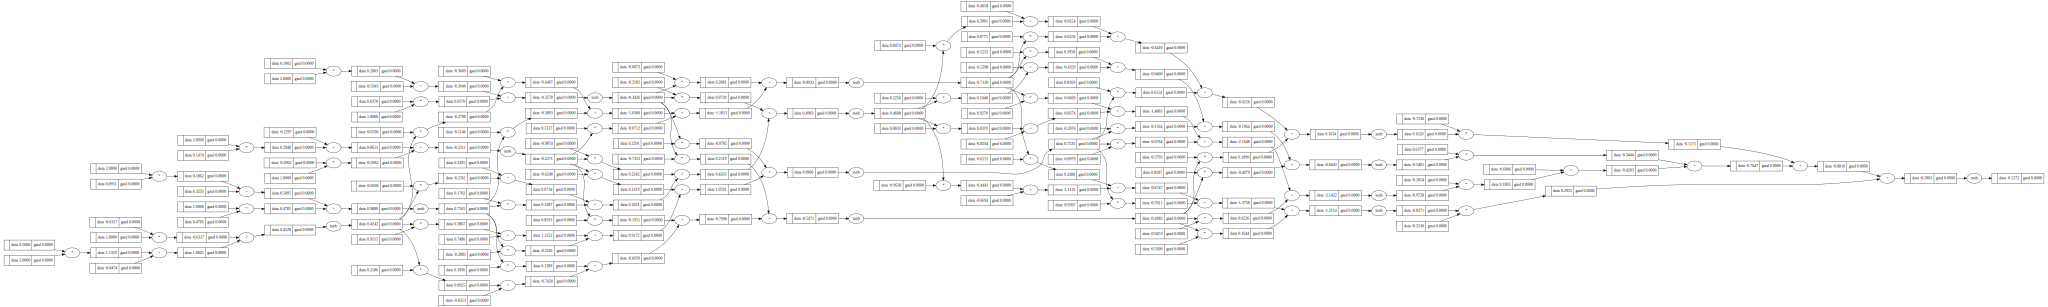

In [6]:
draw_dot(n(x))

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Creating a sample DataFrame
np.random.seed(42)
data = {'Feature1': np.random.rand(100),
        'Feature2': np.random.rand(100),
        'Label': np.where(np.random.rand(100) > 0.5, 1, 0)}

df = pd.DataFrame(data)

# Split the data into features (X) and target variable (y)
X = df[['Feature1', 'Feature2']]
y = df['Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (30,)],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(MLPClassifier(max_iter=1000, random_state=42), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best parameters for the final model
mlp_classifier = MLPClassifier(max_iter=2000, random_state=42, **best_params)
mlp_classifier.fit(X_train_scaled, y_train)

# Predict the target variable on the test data
y_pred = mlp_classifier.predict(X_test_scaled)

# Evaluate the model using accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy of the Neural Network classifier is: {accuracy}")

# Display the predicted values
result_df = pd.DataFrame({'True_Label': y_test, 'Predicted_Label': y_pred})
print("\nPredictions on the test set:")
print(result_df)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perce

Best Hyperparameters: {'hidden_layer_sizes': (10,), 'learning_rate_init': 0.001}
The accuracy of the Neural Network classifier is: 0.5

Predictions on the test set:
    True_Label  Predicted_Label
83           0                1
53           0                0
70           1                0
45           1                1
44           0                1
39           0                0
22           0                1
80           1                0
10           1                1
0            1                1
18           1                0
30           1                0
73           1                1
33           0                0
90           0                1
4            1                1
76           1                0
77           1                1
12           1                0
31           1                1


In [8]:
xs = X_train_scaled
ys = y_train
# desired targets
df.head(15)

,Feature1,Feature2,Label
0,0.374540,0.031429,1
1,0.950714,0.636410,0
2,0.731994,0.314356,0
3,0.598658,0.508571,1
4,0.156019,0.907566,1
5,0.155995,0.249292,0
6,0.058084,0.410383,0
7,0.866176,0.755551,1
8,0.601115,0.228798,0
9,0.708073,0.076980,0


In [9]:
for k in range(1000):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
print(k, loss.data)

999 214.99999999999994


In [10]:
# 199 0.5279553642020548

ypred_bin = [1 if x > 0.5 else 0 for x in y_pred]
ypred_bin

[1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1]

In [11]:
d = {
    "ypred": ypred_bin,
    "y": y_test
}

dd = pd.DataFrame(d)
print(dd)


    ypred  y
83      1  0
53      0  0
70      0  1
45      1  1
44      1  0
39      0  0
22      1  0
80      0  1
10      1  1
0       1  1
18      0  1
30      0  1
73      1  1
33      0  0
90      1  0
4       1  1
76      0  1
77      1  1
12      0  1
31      1  1


In [12]:
accuracy_score(ypred_bin,y_test)

0.5

In [ ]:
draw_dot(loss)